# RP-GPFA: Textured Bouncing-Ball



Observations $\mathcal{X} = \{ x_{t}, t=1:T \}$: a column of pixels whose intensity are stochastically modulated by a latent variable (the ball). **Importantly**: The Mean and Variance of each pixel remains constant, only higher moments depends on the ball position such that the generative model cannot be modeled by gaussian distribtuion.

The conditional independence relationship factorises across time ($t$):

$$ \mathsf{P_{\theta}}(\mathcal{X}, \mathcal{Z}) = \mathsf{p_{\theta_z}}(\mathcal{Z}) \prod_{t} \left( \mathsf{p_{0,t}}(\mathsf{x_{t}}) \frac{\mathsf{f_{\theta}}(\mathsf{z_{t}} | \mathsf{x_{t}})}{\mathsf{F_{\theta}}(\mathsf{z}_{t})} \right) $$


In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

from recognition_parametrised_model import RPM
from utils_process import plot_loss, plot_rpgpfa_summary, plot_rpgpfa_mixture
from utils_demo import generate_2D_latent, generate_skewed_pixel_from_latent 
import torch.nn.functional as F

# Reproducibility
np.random.seed(1)
torch.manual_seed(1)

# GPUs ?
dtype = torch.float64
torch.set_default_dtype(dtype)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Generate Observations:

In [2]:
# Dimension of the observations
num_observation = 20
dim_observation = 20
len_observation = 50
num_inducing = 20

# Oscillation Speed
omega = 0.5

# Oscillations Parameters
Fz = 10  # Sampling Frequency [Hz]
T = int(len_observation / Fz)  # Sample Length [sec]

# Random initializations and Oscillation
theta = 2*np.pi*np.random.rand(num_observation)
z0 = torch.tensor(np.array([np.cos(theta), np.sin(theta)]).T)
zt, _ = generate_2D_latent(T, Fz
                           , omega, z0)

# Distribution parameters
scale_th = 0.15
shape_max_0 = 1000
sigma2 = 0.01

# True Latent
latent_true = zt[:, 1:, 0] .unsqueeze(-1)

# Sample Observations
samples = generate_skewed_pixel_from_latent(latent_true, dim_observation, scale_th=scale_th, sigma2=sigma2)

# Convert Observations
observations = torch.tensor(samples, dtype=dtype, device=device)

Plot Distribution and Typical Sample

Mean1: -5.33e-04| Var1: 1.00e+00
Mean2: 2.63e-03| Var2: 1.01e+00


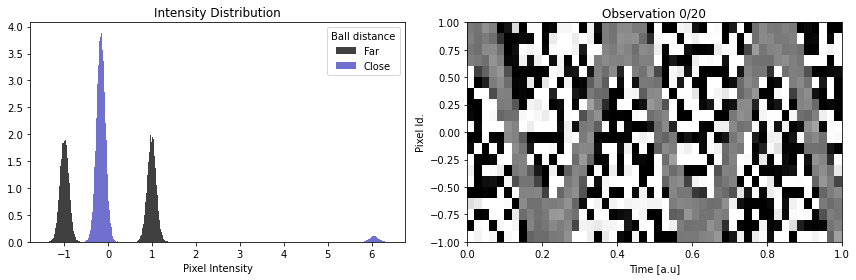

In [3]:
# Sample from distribution
N = 100000
latent_test = torch.empty(N, 3, 1)
latent_test[:, 0, 0] = 1
latent_test[:, 1, 0] = 0
latent_test[:, 2, 0] = -1
observation_samples = generate_skewed_pixel_from_latent(latent_test, 30, scale_th=scale_th, sigma2=sigma2)

# Plot Distribution
plt.figure(figsize=(6 * 2, 4))
plt.subplot(1, 2, 1)
s1 = observation_samples[:, 0, 0]
s2 = observation_samples[:, 0, 24]
plt.hist(s1, bins=500, density=True, alpha=0.75, color=[0.00, 0.00, 0.00], label='Far')
plt.hist(s2, bins=500, density=True, alpha=0.75, color=[0.25, 0.25, 0.75], label='Close')
plt.xlabel('Pixel Intensity')
plt.title('Intensity Distribution')
plt.legend(title='Ball distance')
print('Mean1: %.2e' % s1.mean() + '| Var1: %.2e' % s1.var())
print('Mean2: %.2e' % s2.mean() + '| Var2: %.2e' % s2.var())

# Plot Typical Observation
egobs = 0
pixel_plot = [0, int(dim_observation / 4), 4 * int(dim_observation / 4) -1  ]
plot_observations = not(torch.cuda.is_available())
plt.subplot(1, 2, 2)
plt.imshow(samples[0].transpose(-1, -2), aspect='auto', cmap='gray', extent=[0, 1, -1, 1], vmin=-1, vmax=1)
plt.title('Observation ' + str(egobs) + '/' + str(num_observation))
plt.ylabel('Pixel Id.')
plt.xlabel('Time [a.u]')
plt.tight_layout()

observations = (observations,)



Init and Fit:

In [4]:
# Set up observation / inducing locations
observation_locations = torch.linspace(0, 1, len_observation, dtype=dtype, device=device).unsqueeze(-1)
inducing_locations = observation_locations[
    torch.floor(torch.linspace(0, len_observation - 1, 50)).numpy().astype(int)
]



In [5]:
prior_params = {
    'gp_kernel': 'RBF',
    'scale': 1,
    'lengthscale': 0.01,
    'fit_kernel_scale': False,
    'fit_kernel_scale_prior': False,
    'fit_kernel_lengthscale': True,
    'fit_kernel_lengthscale_prior': True,
    'fit_prior_mean_param': True,
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
}

factors_params = {
    'channels': [[]],
    'kernel_conv': [[]],
    'kernel_pool': [[]],
    'dim_hidden': [[20]],
    'non_linearity': [F.relu],
    'covariance': ['fixed_diag'],
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
}

auxiliary_params = {
    'channels': [[]],
    'kernel_conv': [[]],
    'kernel_pool': [[]],
    'dim_hidden': [[20]],
    'non_linearity': [F.relu],
    'covariance': ['fixed_diag'],
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
    'zero_init': True,
    'fixed':True,
}

variational_params = {
    'inference_mode': 'parametrized',  # 'amortized', 'parametrized'
    'covariance': 'full',
    'optimizer': lambda params: torch.optim.Adam(params=params, lr=1e-3),
}

fit_params = {
    'num_epoch': 5000,
    'dim_latent': 1,
    'pct':0.1,
    'prior_params': prior_params,
    'factors_params': factors_params,
    'auxiliary_params': auxiliary_params,
    'variational_params': variational_params,
    'ergodic': False,
}


# Reproducibility
rpm = RPM(
    observations=observations,
    observation_locations=observation_locations,
    inducing_locations=inducing_locations,
    fit_params=fit_params,
)

rpm.fit(observations)







RPM on GPU Observations on cuda:0
Epoch 500/5000 Loss: 2.995038e+00
Epoch 1000/5000 Loss: 2.809169e+00
Epoch 1500/5000 Loss: 2.641642e+00
Epoch 2000/5000 Loss: 2.556224e+00
Epoch 2500/5000 Loss: 2.499295e+00
Epoch 3000/5000 Loss: 2.455103e+00
Epoch 3500/5000 Loss: 2.424171e+00
Epoch 4000/5000 Loss: 2.398499e+00
Epoch 4500/5000 Loss: 2.377396e+00
Epoch 5000/5000 Loss: 2.361126e+00


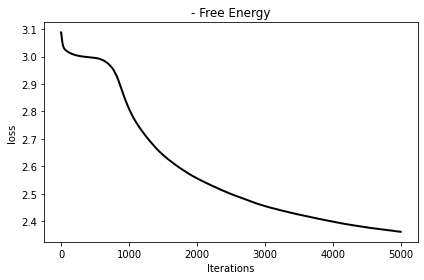

In [6]:
plot_loss(rpm, offset=0)

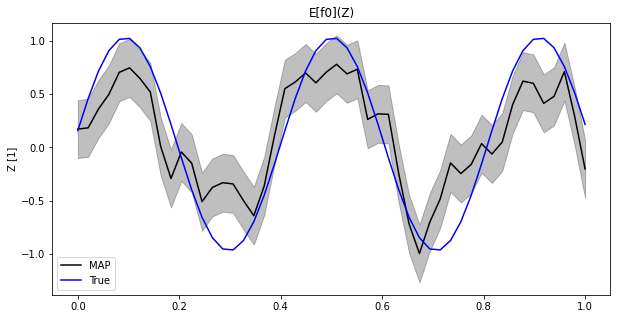

In [9]:
fig = plot_rpgpfa_summary(
    rpm=rpm,
    plot_id_factors=[0],
    plot_id_observations=[1],
    plot_variational=False,
    plot_regressed=True,
    plot_variance=True,
    plot_true=True,
    latent_true=latent_true,
    regress_param=None,
    plot_type='linear',
)
fig.set_figwidth(10)
fig.set_figheight(5)